In [1]:
# ===================================================================
# CLARITy - PyTorch Training Script (DenseNet121)
# ===================================================================

import warnings
warnings.filterwarnings('ignore')

import torch, torch.nn as nn, torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# ---------------- CONFIG ----------------
BASE_PATH    = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # update
CSV_FILE     = BASE_PATH / "Data_Entry_2017.csv"
SAVE_PATH    = Path("./saved_model")
SAVE_PATH.mkdir(exist_ok=True)

IMG_SIZE     = 224
BATCH_SIZE   = 16
EPOCHS       = 10
LR           = 1e-4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- LOAD CSV ----------------
df = pd.read_csv(CSV_FILE)

# Map image paths
image_map = {}
for folder in BASE_PATH.iterdir():
    if folder.is_dir() and folder.name.startswith('images_'):
        for img in (folder/"images").glob("*.png"):
            image_map[img.name] = img

df = df[df['Image Index'].isin(image_map)].copy()
df['full_path'] = df['Image Index'].map(image_map)

# Multi-labels
diseases = ['No Finding','Atelectasis','Cardiomegaly','Effusion','Infiltration',
            'Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
            'Emphysema','Fibrosis','Pleural_Thickening','Hernia']

df['labels'] = df['Finding Labels'].apply(lambda s: [1 if d in s.split("|") else 0 for d in diseases])

# ---------------- SPLIT DATA ----------------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)
train_df, val_df, test_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Device: cuda
Train: 89696 Val: 11212 Test: 11212


In [3]:
# ---------------- DATASET ----------------
class XrayDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_path']).convert('RGB')
        img = self.transform(img)
        label = torch.FloatTensor(row['labels'])
        return img, label

In [4]:
# ---------------- TRANSFORMS ----------------
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = XrayDataset(train_df, train_tf)
val_ds   = XrayDataset(val_df,   test_tf)
test_ds  = XrayDataset(test_df,  test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
# ---------------- MODEL ----------------
model = models.densenet121(weights='DEFAULT')
model.classifier = nn.Linear(model.classifier.in_features, len(diseases))
model = model.to(DEVICE)

# ---------------- LOSS & OPTIMIZER ----------------
label_arr = np.vstack(df['labels'])
pos_weight = torch.FloatTensor(label_arr.sum(axis=0).max()/(label_arr.sum(axis=0)+1)).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [6]:
# ---------------- TRAINING ----------------
history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}
best_auc = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    running_auc  = 0
    for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # batch AUC
        pred = torch.sigmoid(out).detach().cpu().numpy()
        true = lbls.cpu().numpy()
        batch_auc = np.mean([roc_auc_score(true[:,i], pred[:,i]) if true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])
        running_auc += batch_auc

    train_loss = running_loss / len(train_loader)
    train_auc  = running_auc / len(train_loader)

    # Validate
    model.eval()
    val_loss, val_preds, val_true = 0, [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            val_loss += criterion(out, lbls).item()
            val_preds.append(torch.sigmoid(out).cpu().numpy())
            val_true.append(lbls.cpu().numpy())
    val_loss /= len(val_loader)
    val_preds = np.vstack(val_preds)
    val_true  = np.vstack(val_true)
    val_auc = np.mean([roc_auc_score(val_true[:,i], val_preds[:,i]) if val_true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1} -> Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), SAVE_PATH/"best_model.pth")
        print(f" Saved best model with Val AUC: {best_auc:.4f}")

    scheduler.step(val_auc)

Epoch 1/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:45<00:00,  2.85it/s]


Epoch 1 -> Train Loss: 0.8107, Train AUC: 0.6264 | Val Loss: 0.7810, Val AUC: 0.7854
 Saved best model with Val AUC: 0.7854


Epoch 2/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:39<00:00,  2.86it/s]


Epoch 2 -> Train Loss: 0.7481, Train AUC: 0.6448 | Val Loss: 0.7173, Val AUC: 0.8123
 Saved best model with Val AUC: 0.8123


Epoch 3/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:40<00:00,  2.86it/s]


Epoch 3 -> Train Loss: 0.7187, Train AUC: 0.6506 | Val Loss: 0.7146, Val AUC: 0.8180
 Saved best model with Val AUC: 0.8180


Epoch 4/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:36<00:00,  2.86it/s]


Epoch 4 -> Train Loss: 0.7038, Train AUC: 0.6543 | Val Loss: 0.7221, Val AUC: 0.8218
 Saved best model with Val AUC: 0.8218


Epoch 5/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:37<00:00,  2.86it/s]


Epoch 5 -> Train Loss: 0.6844, Train AUC: 0.6573 | Val Loss: 0.7064, Val AUC: 0.8235
 Saved best model with Val AUC: 0.8235


Epoch 6/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:39<00:00,  2.86it/s]


Epoch 6 -> Train Loss: 0.6733, Train AUC: 0.6598 | Val Loss: 0.7101, Val AUC: 0.8261
 Saved best model with Val AUC: 0.8261


Epoch 7/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:38<00:00,  2.86it/s]


Epoch 7 -> Train Loss: 0.6617, Train AUC: 0.6624 | Val Loss: 0.7230, Val AUC: 0.8235


Epoch 8/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:40<00:00,  2.86it/s]


Epoch 8 -> Train Loss: 0.6493, Train AUC: 0.6638 | Val Loss: 0.7144, Val AUC: 0.8316
 Saved best model with Val AUC: 0.8316


Epoch 9/10 [Train]: 100%|██████████████████████████████████████████████████████████| 5606/5606 [32:42<00:00,  2.86it/s]


Epoch 9 -> Train Loss: 0.6413, Train AUC: 0.6652 | Val Loss: 0.7145, Val AUC: 0.8305


Epoch 10/10 [Train]: 100%|█████████████████████████████████████████████████████████| 5606/5606 [32:52<00:00,  2.84it/s]


Epoch 10 -> Train Loss: 0.6343, Train AUC: nan | Val Loss: 0.7012, Val AUC: 0.8330
 Saved best model with Val AUC: 0.8330


In [7]:
# ---------------- TEST EVALUATION ----------------
model.load_state_dict(torch.load(SAVE_PATH/"best_model.pth"))
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Test"):
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        test_preds.append(torch.sigmoid(out).cpu().numpy())
        test_true.append(lbls.numpy())

test_preds = np.vstack(test_preds)
test_true  = np.vstack(test_true)
test_auc = np.mean([roc_auc_score(test_true[:,i], test_preds[:,i]) if test_true[:,i].sum()>0 else 0.5 for i in range(len(diseases))])
print("Test mean AUC:", test_auc)

Test: 100%|██████████████████████████████████████████████████████████████████████████| 701/701 [03:15<00:00,  3.58it/s]

Test mean AUC: 0.8301597963568095


Training plot saved.


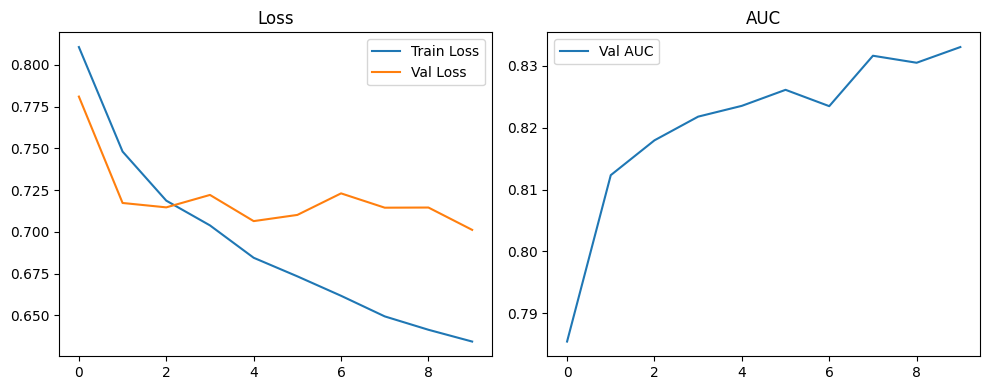

In [11]:
# ---------------- PLOT ----------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_auc'], label='Val AUC')
plt.legend(); 
plt.title("AUC")
plt.tight_layout()
plt.savefig(SAVE_PATH/"training_plot.png")
print("Training plot saved.")

In [27]:
# -------------------------------------------------------
# 1. Imports
# -------------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm

In [28]:
# -------------------------------------------------------
# 2. Set Model & Device
# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
# -------------------------------------------------------
# 3. Gather Predictions on Test Set
# -------------------------------------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 701/701 [03:17<00:00,  3.55it/s]


In [30]:
# -------------------------------------------------------
# 4. Define Class Names (VERY IMPORTANT)
# -------------------------------------------------------
# If you used ImageFolder or a custom Dataset, use its classes attribute:
# class_names = train_dataset.classes  
# or manually define:
class_names = [
    "Atelectasis", "Effusion", "Infiltration", "No Finding",
    "Consolidation", "Nodule", "Mass", "Cardiomegaly", "Pneumothorax",
    "Edema", "Emphysema", "Pleural_Thickening", "Fibrosis",
    "Pneumonia", "Hernia"
]

In [34]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Ensure both arrays are 2D
if y_true.ndim == 1:
    y_true = np.eye(len(class_names))[y_true]

# ✅ Convert logits/probabilities to binary using 0.5 threshold
if y_pred.ndim == 1:
    y_pred_bin = np.eye(len(class_names))[y_pred]
elif y_pred.ndim == 2 and not np.array_equal(y_pred, y_pred.astype(bool)):
    y_pred_bin = (y_pred > 0.5).astype(int)
else:
    y_pred_bin = y_pred.astype(int)

# ✅ Align shape
min_len = min(len(y_true), len(y_pred_bin))
y_true = y_true[:min_len]
y_pred_bin = y_pred_bin[:min_len]

print("\nClassification Report (Multi-Label):")
print(classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0))

# ✅ Weighted metrics
f1 = f1_score(y_true, y_pred_bin, average='weighted', zero_division=0)
precision = precision_score(y_true, y_pred_bin, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_bin, average='weighted', zero_division=0)

print(f"\nF1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Classification Report (Multi-Label):
                    precision    recall  f1-score   support

       Atelectasis       0.79      0.62      0.69      6104
          Effusion       0.36      0.21      0.27      1107
      Infiltration       0.22      0.53      0.31       267
        No Finding       0.55      0.41      0.47      1332
     Consolidation       0.39      0.02      0.04      1947
            Nodule       0.37      0.27      0.31       561
              Mass       0.35      0.17      0.23       619
      Cardiomegaly       0.04      0.09      0.06       151
      Pneumothorax       0.35      0.39      0.37       515
             Edema       0.14      0.08      0.10       422
         Emphysema       0.13      0.55      0.20       220
Pleural_Thickening       0.31      0.37      0.34       220
          Fibrosis       0.08      0.28      0.13       165
         Pneumonia       0.22      0.17      0.19       327
            Hernia       0.09      0.61      0.15        18



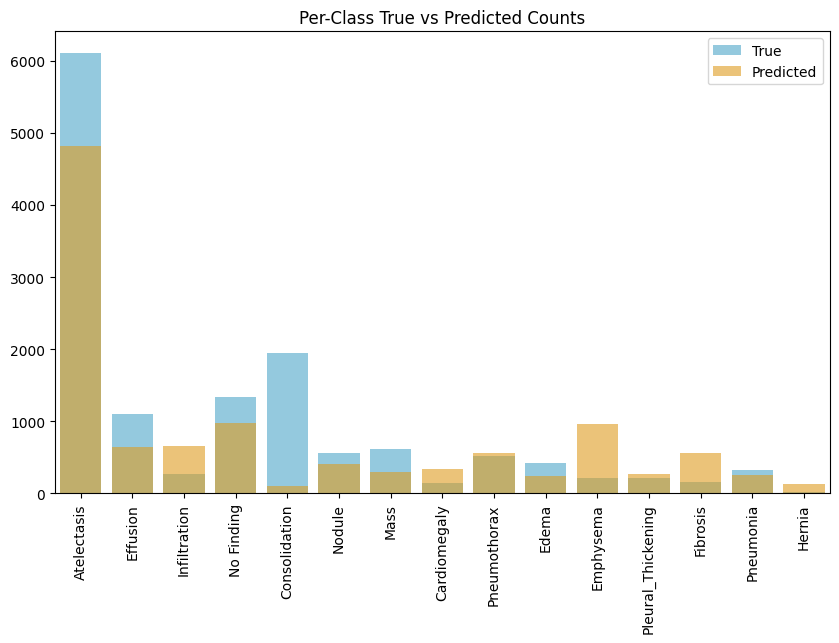

In [35]:
true_counts = y_true.sum(axis=0)
pred_counts = y_pred_bin.sum(axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=true_counts, color="skyblue", label="True")
sns.barplot(x=class_names, y=pred_counts, color="orange", alpha=0.6, label="Predicted")
plt.xticks(rotation=90)
plt.title("Per-Class True vs Predicted Counts")
plt.legend()
plt.show()